In [203]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from shutil import copy2
from keras.preprocessing import image
from keras import models, layers, optimizers, losses, metrics

plt.style.use('seaborn')

In [2]:
attribute_labels = "attribute_labels.json"  #~590Mb
mvc_info = "mvc_info.json"                  #~140Mb

img_mvc = "./images/mvc/"
img_selected = "./images/images_selected/"

In [ ]:
df_labels = pd.read_json(attribute_labels)
df_mvc_info = pd.read_json(mvc_info)

In [27]:
print(df_labels.shape)
print(df_mvc_info.shape)

(161260, 266)
(161260, 23)


In [22]:
print(df_labels.columns)
print('-'*75)
print(df_mvc_info.columns)

Index(['AlineDresses', 'AnimalPrint', 'Anoraks', 'Argyle', 'Asymmetrical',
       'Athletic', 'BabyDollDresses', 'BalconetteBras', 'Bandeau',
       'BandeauBras',
       ...
       'Zipper', 'fiftyU', 'filename', 'halfZip', 'hundred1U', 'hundred2O',
       'hundred2U', 'itemN', 'quarter3Zip', 'quarterZip'],
      dtype='object', length=266)
---------------------------------------------------------------------------
Index(['brandId', 'brandName', 'catNum', 'category', 'colourId', 'colourName',
       'image_4x_height', 'image_4x_width', 'image_url_2x', 'image_url_4x',
       'image_url_multiView', 'image_url_thumbnails', 'price', 'productGender',
       'productId', 'productName', 'productTypeId', 'styleId', 'subCategory1',
       'subCategory2', 'total_style', 'viewId', 'zetaCategory'],
      dtype='object')


In [145]:
# select only the columns we are interested in, for both df_labels and df_mvc_info
colors = ['Beige', 'Black', 'Blue', 'Bronze', 'Brown', 'Burgundy',
          'Coral', 'Gold', 'Gray', 'Green', 'Olive', 'Orange', 'Pink', 'Purple',
          'Red', 'Silver', 'White', 'Yellow', 'filename', 'itemN']

gender = ['productGender', 'styleId', 'productId']

# dropping duplicate photos
df_colors = df_labels[colors].drop_duplicates(subset="itemN", keep="first", inplace=False)
df_gender = df_mvc_info[gender].drop_duplicates(subset="styleId", keep="first", inplace=False)

print(df_colors.shape)
print(df_gender.shape)

(37499, 20)
(37499, 3)


In [146]:
df_colors.head(2)

,Beige,Black,Blue,Bronze,Brown,Burgundy,Coral,Gold,Gray,Green,Olive,Orange,Pink,Purple,Red,Silver,White,Yellow,filename,itemN
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,p7258521_s3163710_v0,3163710.0
5,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,p7258521_s3163713_v0,3163713.0


In [147]:
df_gender.head(2)

,productGender,styleId,productId
0,"""Mens""",3163710,7258521
5,"""Mens""",3163713,7258521


In [148]:
# we can join the filename column from df_colors to df_gender by itemN-styleId
# first we need to convert itemN column to integer (rounded first to avoid missconversion)
df_colors.itemN = df_colors.itemN.round().astype(int)

37499

In [149]:
# merge to add the file name to the gender table
df_gender = pd.merge(df_gender, df_colors[['filename']], 
                     left_index=True, right_index=True, 
                     how='left'
                    )

# check that length still the same
len(df_gender)

37499

In [150]:
df_gender.head(2)

,productGender,styleId,productId,filename
0,"""Mens""",3163710,7258521,p7258521_s3163710_v0
5,"""Mens""",3163713,7258521,p7258521_s3163713_v0


In [151]:
df_gender["filename"] = df_gender["filename"].map(str)+'.jpg'

In [152]:
df_gender[['productGender','styleId']].groupby('productGender').count().sort_values(by='styleId')

,styleId
productGender,
"""Unisex""",14
"""Mens""",13170
"""Womens""",24315


In [153]:
# we will note be using the "Unisex" gender as there are too few elements
df_gender = df_gender[df_gender.productGender != '"Unisex"']
len(df_gender)

37485

In [154]:
os.makedirs("data-"+"Men".lower()+"-"+"women".lower()+"/train/"+"men".lower(), exist_ok=True)

In [126]:
df_gender[df_gender["productGender"].str.contains("Men")].sample(n=5, random_state=2018)["filename"].tolist()

['p8640337_s3418098_v0',
 'p8555676_s3225663_v0',
 'p8579144_s3279578_v0',
 'p7930174_s1784105_v0',
 'p7973539_s3230256_v0']

In [157]:
def structure_images(df, key, class1, class2, n_images, data_split, images_path):
    
    """
    - key is the type of classification i.e "productGender", "subCategory2" ... 
    - class1 and class2 are integers that need to match the category labels
    - n_images is n images per class
    - data_split refers to the train, test, val proportions, need to be in format [train, test, val], ie. [0.8, 0.1, 0.1]
    - images_path is the absolute path to the img folder without including the img folder since imgs are labeled with the path name
    """
        
    clothes_1 = df[df[key].str.contains(class1)].sample(n=n_images, random_state=2018)["filename"].tolist()
    clothes_2 = df[df[key].str.contains(class2)].sample(n=n_images, random_state=2018)["filename"].tolist()
    
    os.makedirs("data-"+class1.lower()+"-"+class2.lower()+"/train/"+class1.lower(), exist_ok=True)
    os.makedirs("data-"+class1.lower()+"-"+class2.lower()+"/test/"+class1.lower(), exist_ok=True)
    os.makedirs("data-"+class1.lower()+"-"+class2.lower()+"/valid/"+class1.lower(), exist_ok=True)
    os.makedirs("data-"+class1.lower()+"-"+class2.lower()+"/train/"+class2.lower(), exist_ok=True)
    os.makedirs("data-"+class1.lower()+"-"+class2.lower()+"/test/"+class2.lower(), exist_ok=True)
    os.makedirs("data-"+class1.lower()+"-"+class2.lower()+"/valid/"+class2.lower(), exist_ok=True)
        
    clothes_1_train, clothes_1_test, clothes_1_val = np.split(clothes_1,
                                                       [int(data_split[0]*len(clothes_1)),
                                                        int((data_split[0] + data_split[1])*len(clothes_1))]
                                                      )

    clothes_2_train, clothes_2_test, clothes_2_val = np.split(clothes_2,
                                                       [int(data_split[0]*len(clothes_2)),
                                                        int((data_split[0] + data_split[1])*len(clothes_2))]
                                                      )
    
    clothes_1_list = [clothes_1_train, clothes_1_test, clothes_1_val]
    clothes_2_list = [clothes_2_train, clothes_2_test, clothes_2_val]    
        
    path_cwd = os.getcwd() #output path by default
    folders = {0: "train", 1: "test",2: "valid"}   
    
    for n, (list_1, list_2) in enumerate(zip(clothes_1_list, clothes_2_list)):
        
        for img_1, img_2 in zip(list_1, list_2):

            full_path_1 = os.path.join(images_path, img_1)
            full_path_2 = os.path.join(images_path, img_2)

            #will move the images from origin to destination folder
            copy2(full_path_1, 
                  os.path.join(path_cwd, "data-" + class1.lower() +"-"+ class2.lower()+ "/" + folders[n] +
                                                "/" + class1.lower() + "/" + img_1)
                 )
            copy2(full_path_2, 
                  os.path.join(path_cwd, "data-" + class1.lower() +"-"+ class2.lower()+"/" + folders[n] +
                                                "/" + class2.lower() + "/" + img_2)
                 )

In [159]:
%%time
structure_images(df_gender, 
                 "productGender", 
                 "Men", 
                 "Women", 
                 10000, 
                 [0.8, 0.1, 0.1], 
                 img_selected)

Wall time: 5min 2s


In [160]:
#links to where the imgs for the model are
train_path = "data-men-women/train"
test_path = "data-men-women/test"
valid_path = "data-men-women/valid"

train_batches = image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    train_path, target_size=(150,150), class_mode="binary", batch_size=200
)
test_batches = image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    test_path, target_size=(150,150), class_mode="binary", batch_size=200
)
valid_batches = image.ImageDataGenerator(rescale=1./255).flow_from_directory(
    valid_path, target_size=(150,150), class_mode="binary", batch_size=200
)

Found 16000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


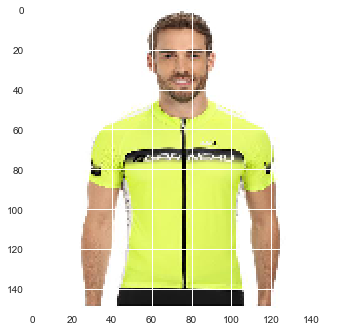

0.0


In [234]:
plt.imshow(train_batches[10][0][20])
plt.show()
print(train_batches[10][1][20]) #0: men, 1: women

In [182]:
%%time
m  = models.Sequential()
m.add(layers.Convolution2D(32, (3,3), activation="relu", input_shape=(150,150,3)))
m.add(layers.MaxPooling2D((2,2)))
m.add(layers.Convolution2D(64, (3,3), activation="relu"))
m.add(layers.MaxPooling2D((2,2)))
m.add(layers.Convolution2D(128, (3,3), activation="relu"))
m.add(layers.MaxPooling2D((2,2)))
m.add(layers.Flatten())
m.add(layers.Dense(128, activation="relu"))
m.add(layers.Dense(64, activation="relu"))
m.add(layers.Dense(1, activation="sigmoid"))

m.compile(
    optimizer=optimizers.rmsprop(),
    loss=losses.binary_crossentropy,
    metrics=[metrics.binary_accuracy]
)

h = m.fit_generator(train_batches, epochs=10, steps_per_epoch=20, 
                    validation_data=valid_batches, validation_steps=20)

Epoch 1/10
20/20 [==============================] - 116s 6s/step - loss: 0.9710 - binary_accuracy: 0.6315 - val_loss: 0.9842 - val_binary_accuracy: 0.5850
Epoch 2/10
20/20 [==============================] - 116s 6s/step - loss: 0.3517 - binary_accuracy: 0.8552 - val_loss: 0.2467 - val_binary_accuracy: 0.9040
Epoch 3/10
20/20 [==============================] - 115s 6s/step - loss: 0.2087 - binary_accuracy: 0.9247 - val_loss: 0.1573 - val_binary_accuracy: 0.9360
Epoch 4/10
20/20 [==============================] - 116s 6s/step - loss: 0.2135 - binary_accuracy: 0.9155 - val_loss: 0.1445 - val_binary_accuracy: 0.9420
Epoch 5/10
20/20 [==============================] - 116s 6s/step - loss: 0.1330 - binary_accuracy: 0.9520 - val_loss: 0.1342 - val_binary_accuracy: 0.9495
Epoch 6/10
20/20 [==============================] - 116s 6s/step - loss: 0.1400 - binary_accuracy: 0.9440 - val_loss: 0.1160 - val_binary_accuracy: 0.9565
Epoch 7/10
20/20 [==============================] - 116s 6s/step - los

In [183]:
loss, acc = m.evaluate_generator(test_batches)
print('loss', loss)
print('accu', acc)

loss 0.10629619807
accu 0.958499985933


In [238]:
m.predict_generator(test_batches)

array([[  9.99841094e-01],
       [  3.20670719e-04],
       [  9.99969006e-01],
       ..., 
       [  9.98487473e-01],
       [  1.02378801e-02],
       [  1.52120006e-03]], dtype=float32)

In [184]:
print((1-acc)*test_batches.samples, "wrongly classified")

83.0000281334 wrongly classified


In [189]:
predictions_test = m.predict_generator(test_batches)

In [239]:
predictions_test.shape

(2000, 1)

In [243]:
predictions_test[0]

array([ 0.99853456], dtype=float32)

1.0   #0: men, 1: women


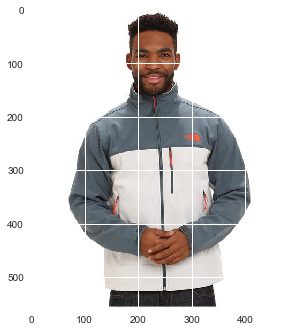

0.0   #0: men, 1: women


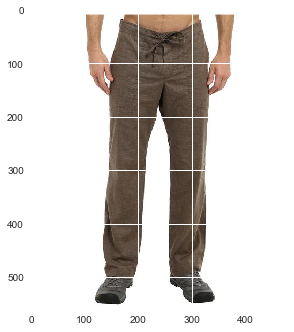

0.0   #0: men, 1: women


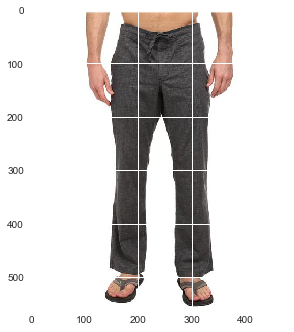

1.0   #0: men, 1: women


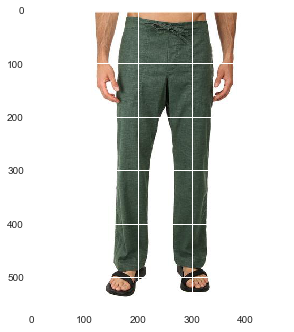

0.0   #0: men, 1: women


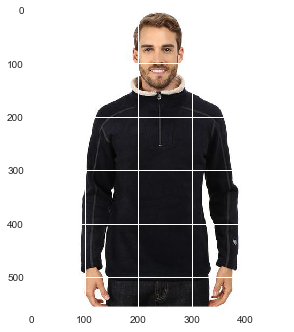

1.0   #0: men, 1: women


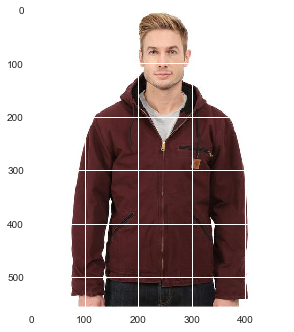

0.0   #0: men, 1: women


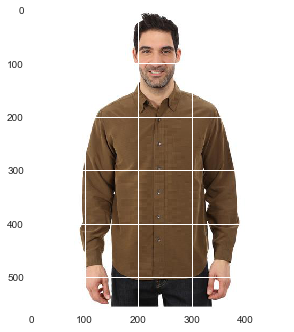

0.0   #0: men, 1: women


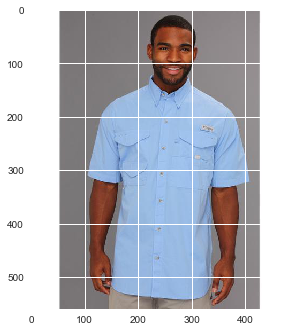

1.0   #0: men, 1: women


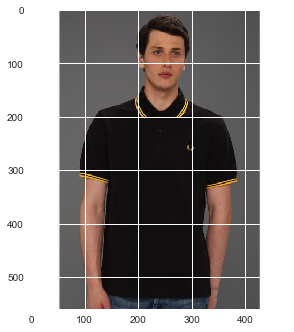

0.0   #0: men, 1: women


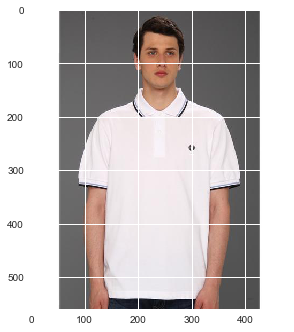

0.0   #0: men, 1: women


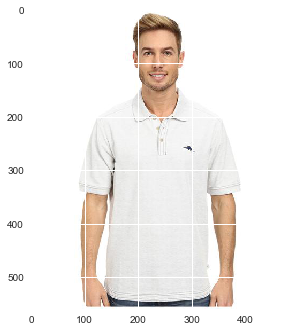

0.0   #0: men, 1: women


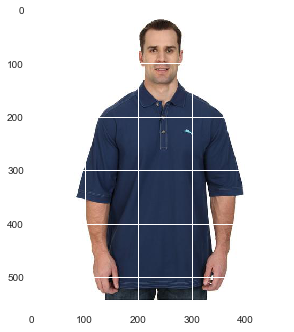

0.0   #0: men, 1: women


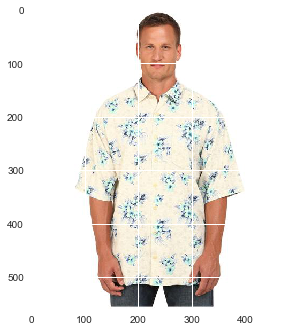

0.0   #0: men, 1: women


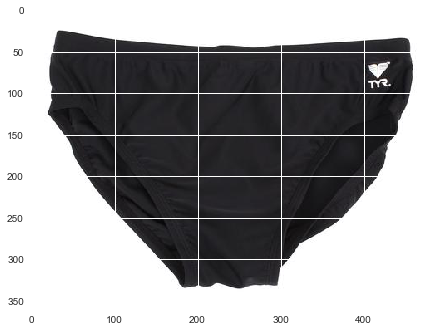

0.0   #0: men, 1: women


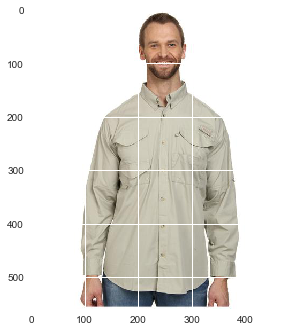

1.0   #0: men, 1: women


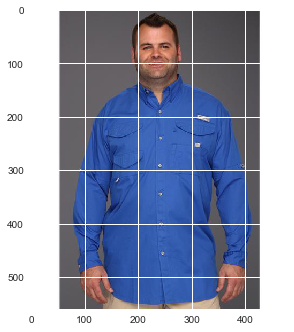

1.0   #0: men, 1: women


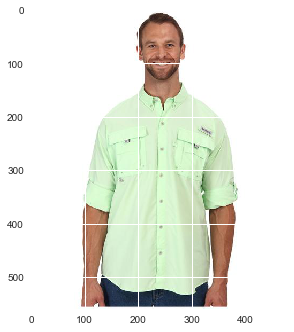

1.0   #0: men, 1: women


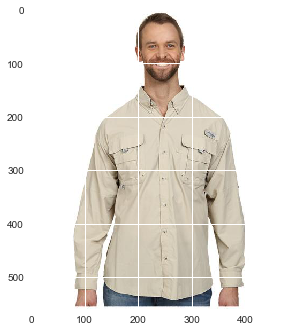

0.0   #0: men, 1: women


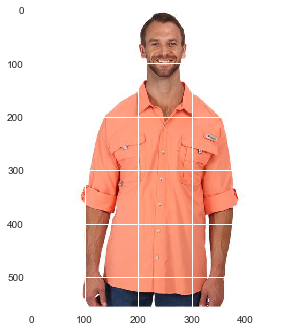

1.0   #0: men, 1: women


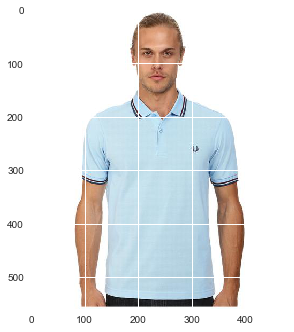

In [244]:
for n in range(20):
    image_path = test_batches.filenames[n]
    full_image_path = os.path.join(os.getcwd(), "data-men-women\\test", image_path)
    print(predictions_test[n][0].round(), "  #0: men, 1: women")
    test_image = mpimg.imread(full_image_path)
    plt.imshow(test_image)
    plt.show()

### It seems this approach is not working to classify genders using clothes. They should all be predicted as men.